# Imports

In [1]:
import pandas as pd
import numpy as np
import math as m
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pylab
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings('ignore')

### Python Version

In [2]:
from platform import python_version
print(python_version())

3.8.5


# Load Datasets

In [3]:
X = pd.read_csv('ced4af35ca8f072dfcfe0b23e8cb324fx.csv', header=None)
y = pd.read_csv('aab2bd7fe40cf91d3550c23007910532y.csv', header=None)
time = pd.read_csv('7bdf781b71e5c0e9b2729d6944cf1d1ctime.csv', header=None)

## Task 1: Preliminary data analysis

In [4]:
print(X.shape, y.shape, time.shape)   # Check the shape of the datasets

(201, 4) (201, 1) (201, 1)


In [5]:
time.rename(columns={0:'t'}, inplace=True)
X.head(5)

,0,1,2,3
0,-3.061566,-1.865197,-2.909812,-0.339428
1,0.244694,2.039161,0.999302,0.612228
2,-1.200967,0.177409,-0.796548,-2.677010
3,-0.727982,-1.556615,0.010395,-1.623008
4,2.204928,0.766196,1.868107,1.431368


In [6]:
# Rename input-data column names

all_headers = [X[0], X[1], X[2], X[3], y[0], time["t"]]
headers = ["sig1", "sig2", "sig3", "sig4", "output", "time"]
combined = pd.concat(all_headers, axis=1, keys=headers)
combined.head()

,sig1,sig2,sig3,sig4,output,time
0,-3.061566,-1.865197,-2.909812,-0.339428,-1.116785,0.000
1,0.244694,2.039161,0.999302,0.612228,1.333889,0.002
2,-1.200967,0.177409,-0.796548,-2.677010,0.216063,0.004
3,-0.727982,-1.556615,0.010395,-1.623008,0.176452,0.006
4,2.204928,0.766196,1.868107,1.431368,0.011043,0.008


#### 1.1 Time Series Plots

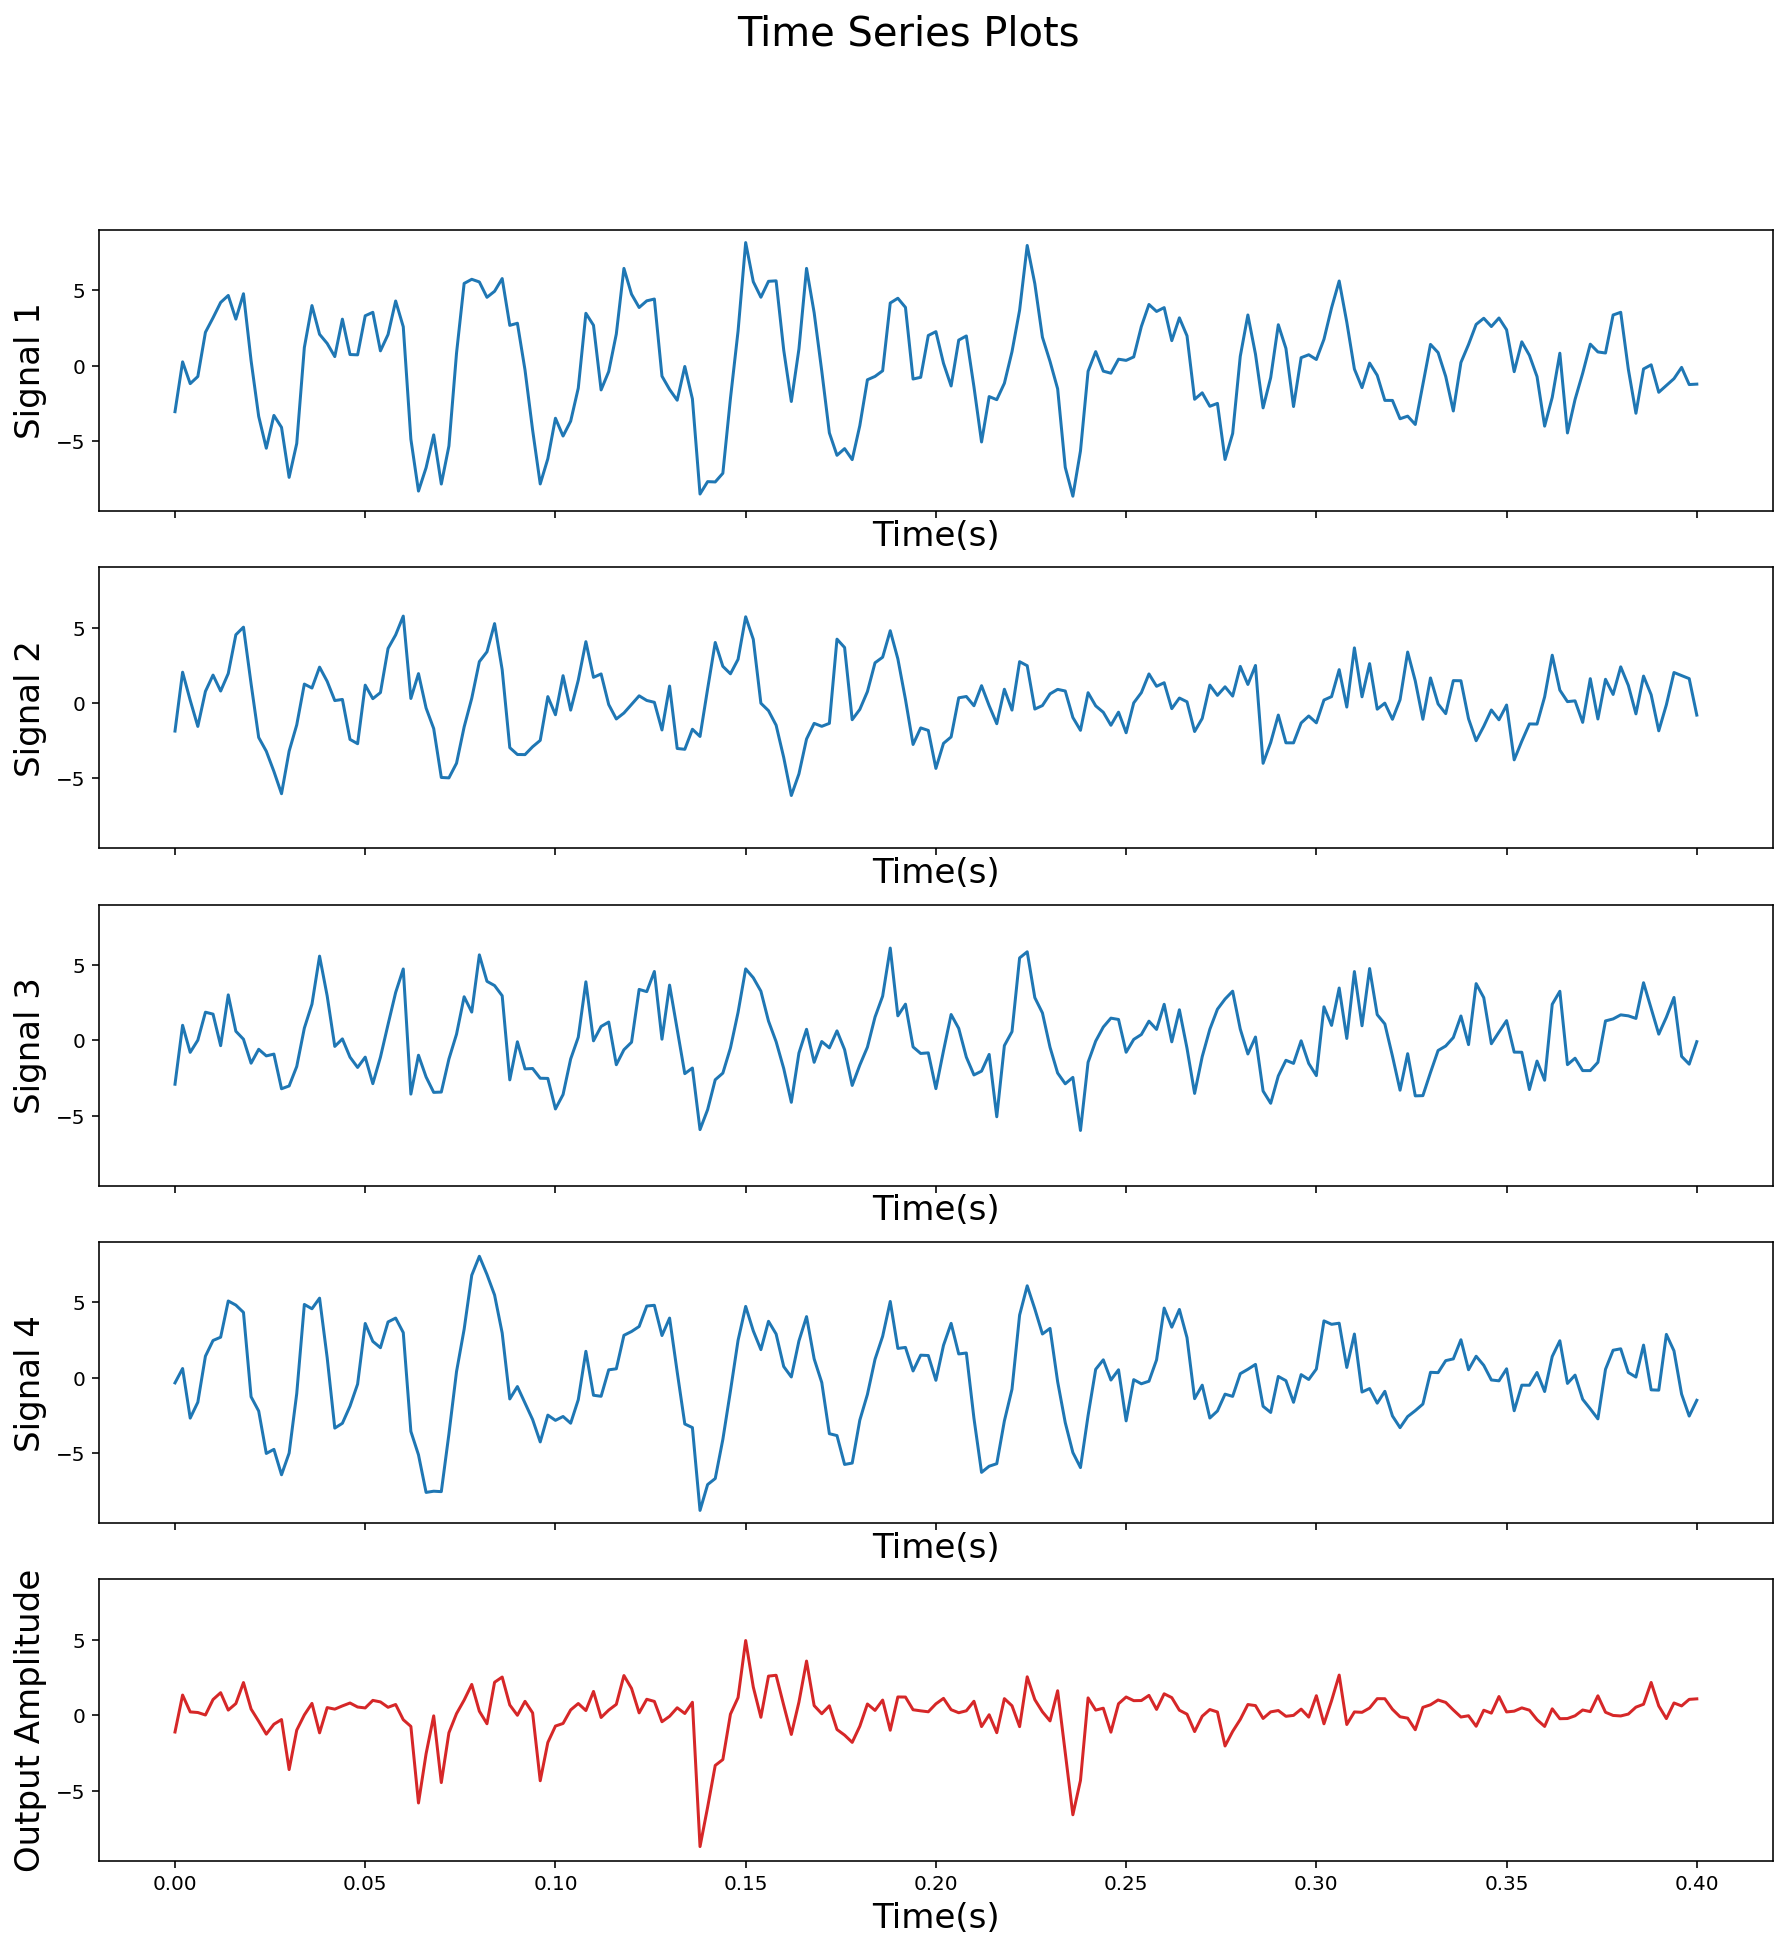

In [7]:
fig, axs = plt.subplots(5, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle('Time Series Plots', size=20)
axs[0].plot(combined['time'], combined['sig1'])
axs[1].plot(combined['time'], combined['sig2'])
axs[2].plot(combined['time'], combined['sig3'])
axs[3].plot(combined['time'], combined['sig4'])
axs[4].plot(combined['time'], combined['output'], 'tab:red')


n=1
for each in axs.flat: 
    if n > 4:
        axs[4].xaxis.get_label().set_fontsize(17)
        axs[4].yaxis.get_label().set_fontsize(17)
        axs[4].set(ylabel='Output Amplitude')
        axs[4].set(xlabel='Time(s)')
    else:  
        each.xaxis.get_label().set_fontsize(17)
        each.yaxis.get_label().set_fontsize(17)
        each.set(xlabel='Time(s)')
        each.set(ylabel=f'Signal {n}')
        n+=1;
    

#### 1.2  Distribution of each EEG signal

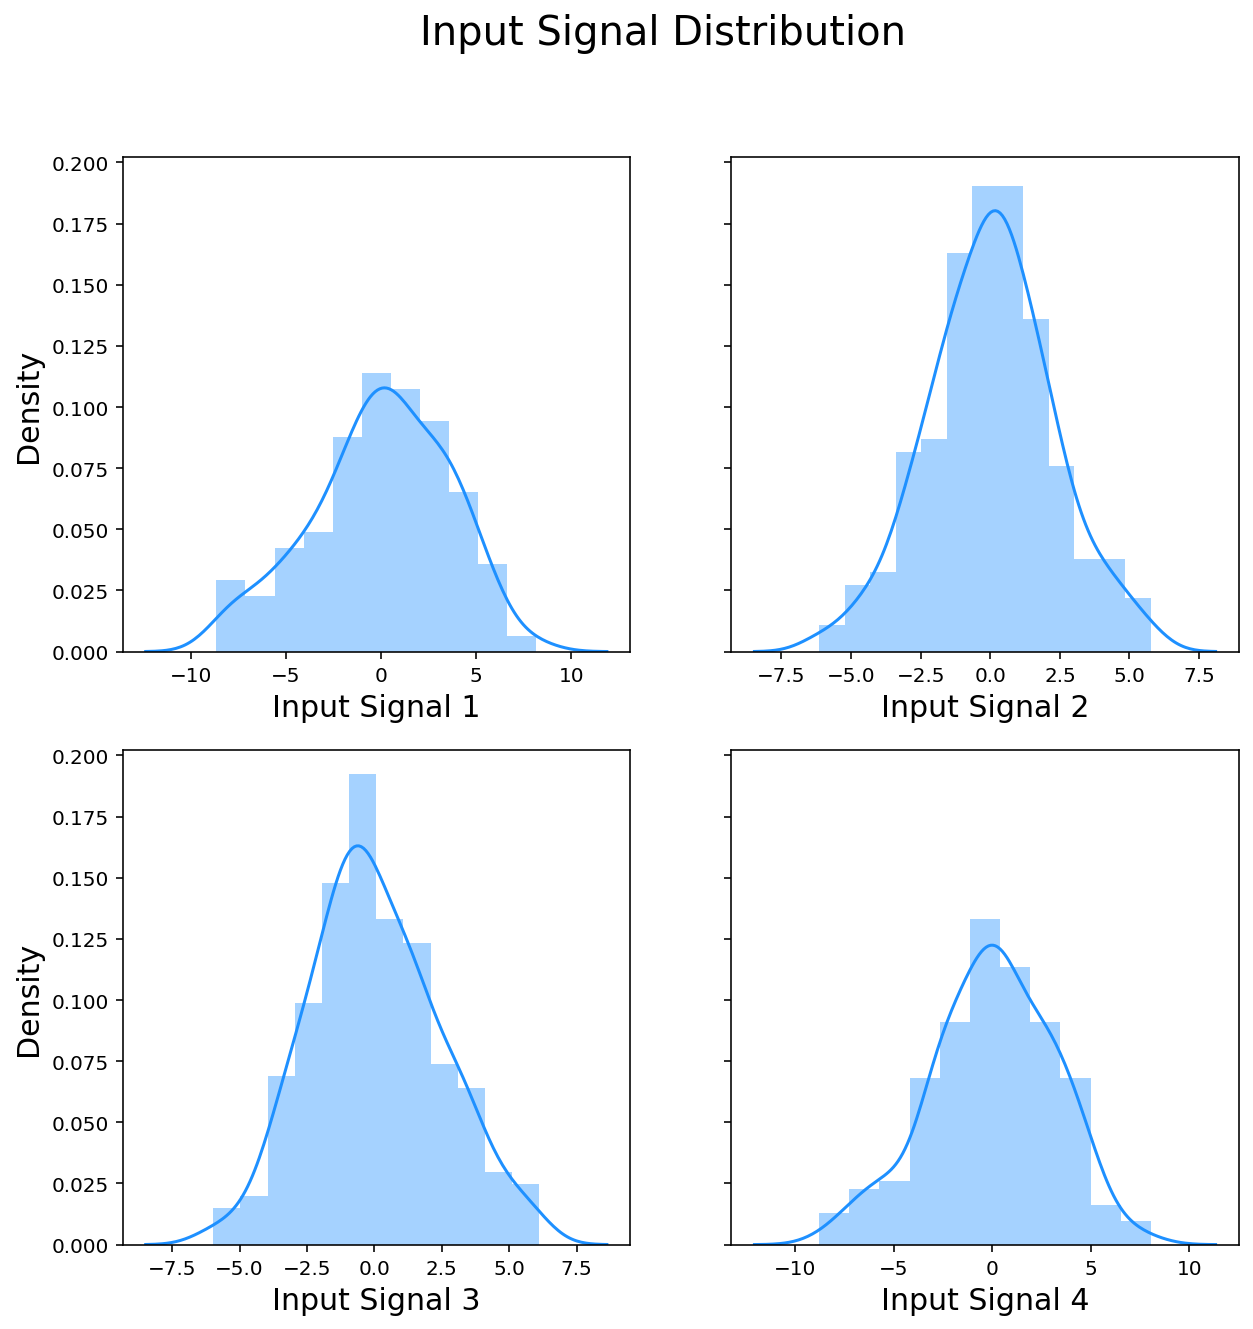

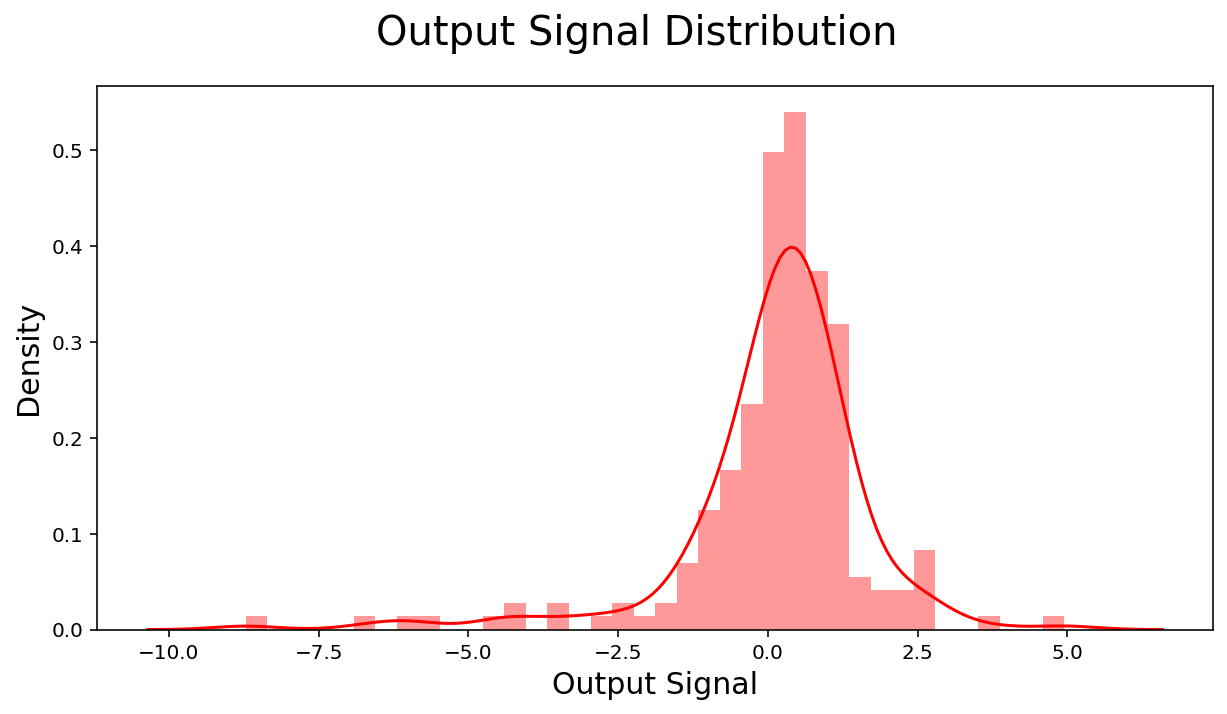

In [8]:
fig, ax = plt.subplots(2, 2, sharey=True, figsize=(10,10))
fig.suptitle('Input Signal Distribution', size=20)

sns.distplot(combined['sig1'] , color="dodgerblue", ax=ax[0,0], axlabel='Input Signal 1')
sns.distplot(combined['sig2'] , color="dodgerblue", ax=ax[0,1], axlabel='Input Signal 2')
sns.distplot(combined['sig3'] , color="dodgerblue", ax=ax[1,0], axlabel='Input Signal 3')
sns.distplot(combined['sig4'] , color="dodgerblue", ax=ax[1,1], axlabel='Input Signal 4');

for each in ax.flat:
    each.xaxis.get_label().set_fontsize(15)
    each.yaxis.get_label().set_fontsize(15)

fig1, ax1 = plt.subplots(1, figsize=(10,5))
fig1.suptitle('Output Signal Distribution', size=20)
ax1.xaxis.get_label().set_fontsize(15)
ax1.yaxis.get_label().set_fontsize(15)


sns.distplot(combined['output'] , color="red", ax=ax1, axlabel='Output Signal');

#### 1.3 Correlation between input signals and output

In [9]:
combined.corr() 
# Comment above line, and uncomment below line to view output correlations
# combined.corr()['output']

,sig1,sig2,sig3,sig4,output,time
sig1,1.000000,0.261976,0.583522,0.805769,0.728899,-0.018324
sig2,0.261976,1.000000,0.520733,0.365883,0.166396,0.011839
sig3,0.583522,0.520733,1.000000,0.710720,0.406975,0.031976
sig4,0.805769,0.365883,0.710720,1.000000,0.570508,-0.004517
output,0.728899,0.166396,0.406975,0.570508,1.000000,0.091947
time,-0.018324,0.011839,0.031976,-0.004517,0.091947,1.000000


#### 1.4   Scatter Plots between input signals and output signals

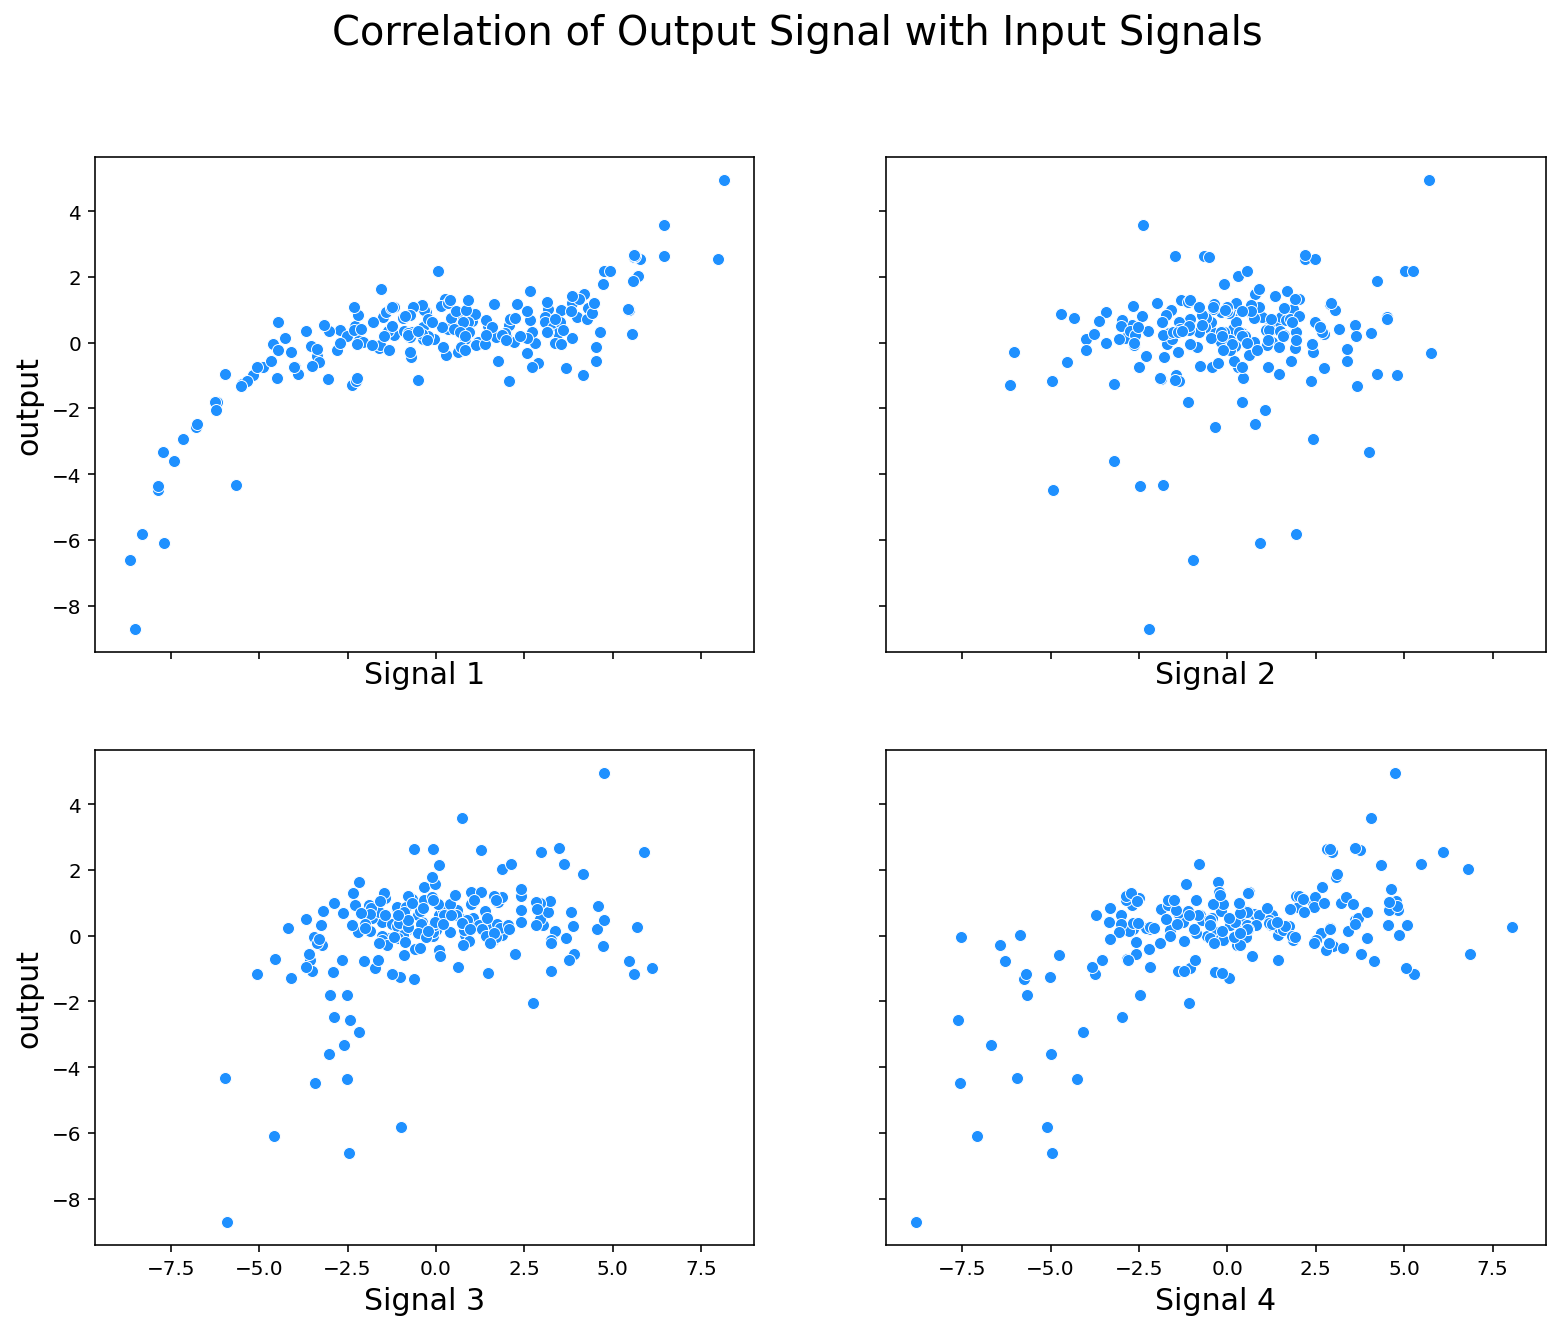

In [10]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(13,10))
fig.suptitle('Correlation of Output Signal with Input Signals', size=20)

ax[0,0].set(xlabel='Signal 1')
ax[0,1].set(xlabel='Signal 2')
ax[1,0].set(xlabel='Signal 3')
ax[1,1].set(xlabel='Signal 4')


sns.scatterplot(x=combined['sig1'], y=combined['output'], color="dodgerblue", ax=ax[0,0])
sns.scatterplot(x=combined['sig2'], y=combined['output'], color="dodgerblue", ax=ax[0,1])
sns.scatterplot(x=combined['sig3'], y=combined['output'], color="dodgerblue", ax=ax[1,0])
sns.scatterplot(x=combined['sig4'], y=combined['output'], color="dodgerblue", ax=ax[1,1]);

for each in ax.flat:
    each.xaxis.get_label().set_fontsize(15)
    each.yaxis.get_label().set_fontsize(15);

## Task 2: Regression – modelling the relationship between EEG signals

### Task 2.1:
Estimate model parameters 𝜽 = {𝜃<sub>1</sub>,𝜃<sub>2</sub>,⋯,𝜃<sub>𝑏𝑖𝑎𝑠</sub>}<sup>𝑇</sup> for every candidate model using Least Squares (𝜽 = (𝐗<sup>𝑇</sup>𝐗)<sup>−1</sup>𝐗<sup>𝑇</sup>𝐲), using the provided input and output EEG datasets (use all the data for training).

In [11]:
def estimate_theta(x_matrix, y):
    """Estimates model parameters using Least Squares"""
    theta = np.linalg.inv(x_matrix.transpose() @ x_matrix) @ x_matrix.transpose() @ y
    return theta

ones = np.array(201*[1])
x1 = combined['sig1']
x2 = combined['sig2']
x3 = combined['sig3']
x4 = combined['sig4']
y0 = combined['output']


In [12]:
# Model 1
X_matrix1 = np.transpose([x4, x1**2, x1**3, x3**4, ones])
theta_model1 = estimate_theta(x_matrix=X_matrix1, y=y0)

# Model 2
X_matrix2 = np.transpose([x3**3, x3**4, ones])
theta_model2 = estimate_theta(x_matrix=X_matrix2, y=y0)

# Model 3
X_matrix3 = np.transpose([x2, x1**3, x3**4, ones])
theta_model3 = estimate_theta(x_matrix=X_matrix3, y=y0)

# Model 4
X_matrix4 = np.transpose([x4, x1**3, x3**4, ones])
theta_model4 = estimate_theta(x_matrix=X_matrix4, y=y0)

# Model 5
X_matrix5 = np.transpose([x4, x1**2, x1**3, x3**4, x1**4, ones])
theta_model5 = estimate_theta(x_matrix=X_matrix5, y=y0)


count = np.arange(1,6)
theta_list = [theta_model1, theta_model2, theta_model3, theta_model4, theta_model5]

for no,thetaa in zip(count,theta_list):
    print(f'Model {no} parameters: {thetaa}')

Model 1 parameters: [-0.03410198 -0.00184957  0.01038181 -0.00194915  0.46855169]
Model 2 parameters: [ 0.01633468 -0.00271399  0.30350114]
Model 3 parameters: [ 0.03810926  0.0098278  -0.00209256  0.44829955]
Model 4 parameters: [-0.03488177  0.01048218 -0.0019905   0.45032921]
Model 5 parameters: [-3.39531264e-02 -2.70164450e-04  1.03476430e-02 -1.94345218e-03
 -3.08319409e-05  4.60656009e-01]


### Task 2.2:
Based on the estimated model parameters, compute the **model residual (error) sum of squared errors (RSS**), for every candidate model.

In [13]:
def compute_RSS(actual_y, input_x, theta):
    """Computes the model residual sum of squared errors given candidate models"""
    
    summation = 0
    for x,y in zip(input_x, actual_y):
        summation = summation + np.square(y - (x@theta))
        
    return summation

In [14]:
rss1 = compute_RSS(y0, X_matrix1, theta_model1)
rss2 = compute_RSS(y0, X_matrix2, theta_model2)
rss3 = compute_RSS(y0, X_matrix3, theta_model3)
rss4 = compute_RSS(y0, X_matrix4, theta_model4)
rss5 = compute_RSS(y0, X_matrix5, theta_model5)

print(f'Model 1 RSS: {rss1:.3f}')
print(f'Model 2 RSS: {rss2:.3f}')
print(f'Model 3 RSS: {rss3:.3f}')
print(f'Model 4 RSS: {rss4:.3f}')
print(f'Model 5 RSS: {rss5:.3f}')

Model 1 RSS: 57.329
Model 2 RSS: 351.415
Model 3 RSS: 57.325
Model 4 RSS: 57.464
Model 5 RSS: 57.309


### Task 2.3:
Compute the log-likelihood function for every candidate model:

In [15]:
def compute_log_likelihood(rss, n):
    """Computes the log likelihood function given residual sum of squared errors
    and number of samples n"""
    
    sigma_sq = rss/(n-1)
    
    log_likelihood = -((n/2)*m.log(2*m.pi)) - (n/2)*m.log(sigma_sq) - (1/(2*sigma_sq))*rss
    return log_likelihood

In [16]:
llh1 = compute_log_likelihood(rss1, len(y0))
llh2 = compute_log_likelihood(rss2, len(y0))
llh3 = compute_log_likelihood(rss3, len(y0))
llh4 = compute_log_likelihood(rss4, len(y0))
llh5 = compute_log_likelihood(rss5, len(y0))

print(f'Model 1 Log Likelihood: {llh1:.3f}')
print(f'Model 2 Log Likelihood: {llh2:.3f}')
print(f'Model 3 Log Likelihood: {llh3:.3f}')
print(f'Model 4 Log Likelihood: {llh4:.3f}')
print(f'Model 5 Log Likelihood: {llh5:.3f}')

Model 1 Log Likelihood: -159.131
Model 2 Log Likelihood: -341.353
Model 3 Log Likelihood: -159.124
Model 4 Log Likelihood: -159.367
Model 5 Log Likelihood: -159.096


In [17]:
# Check maximum log-likelihood value
max([llh1, llh2, llh3, llh4, llh5])

-159.09615673367685

### Task 2.4:
Compute the **Akaike information criterion (AIC)** and **Bayesian information criterion (BIC)** for every candidate model:


In [18]:
import math as m

def compute_AIC(llh, k):
    '''inputs: Log-likelihood, Number of estimable parameters'''
    aic = 2*k - 2*llh
    return aic

def compute_BIC(llh, k, n=len(y0)):
    '''inputs: Log-likelihood, Number of estimable parameters, Length of dataset'''
    bic = k*m.log(n) - 2*llh
    return bic    

In [19]:
aic1 = compute_AIC(llh1, k=5)
aic2 = compute_AIC(llh2, k=3)
aic3 = compute_AIC(llh3, k=4)
aic4 = compute_AIC(llh4, k=4)
aic5 = compute_AIC(llh5, k=6)

bic1 = compute_BIC(llh1, k=5)
bic2 = compute_BIC(llh2, k=3)
bic3 = compute_BIC(llh3, k=4)
bic4 = compute_BIC(llh4, k=4)
bic5 = compute_BIC(llh5, k=6)

all_aic = [aic1, aic2, aic3, aic4, aic5]
aic_min = min(all_aic)
all_bic = [bic1, bic2, bic3, bic4, bic5]
bic_min = min(all_bic)

print(f'Model 1 AIC: {aic1:.2f}, AIC difference: {aic1 - aic_min:.2f}, BIC: {bic1:.2f}, BIC difference: {bic1 - bic_min:.2f}')
print(f'Model 2 AIC: {aic2:.2f}, AIC difference: {aic2 - aic_min:.2f}, BIC: {bic2:.2f}, BIC difference: {bic2 - bic_min:.2f}')
print(f'Model 3 AIC: {aic3:.2f}, AIC difference: {aic3 - aic_min:.2f}, BIC: {bic3:.2f}, BIC difference: {bic3 - bic_min:.2f}')
print(f'Model 4 AIC: {aic4:.2f}, AIC difference: {aic4 - aic_min:.2f}, BIC: {bic4:.2f}, BIC difference: {bic4 - bic_min:.2f}')
print(f'Model 5 AIC: {aic5:.2f}, AIC difference: {aic5 - aic_min:.2f}, BIC: {bic5:.2f}, BIC difference: {bic5 - bic_min:.2f}')

Model 1 AIC: 328.26, AIC difference: 2.01, BIC: 344.78, BIC difference: 5.32
Model 2 AIC: 688.71, AIC difference: 362.46, BIC: 698.62, BIC difference: 359.15
Model 3 AIC: 326.25, AIC difference: 0.00, BIC: 339.46, BIC difference: 0.00
Model 4 AIC: 326.73, AIC difference: 0.49, BIC: 339.95, BIC difference: 0.49
Model 5 AIC: 330.19, AIC difference: 3.94, BIC: 350.01, BIC difference: 10.55


### Task 2.5:
Check the distribution of model prediction errors (residuals) for each candidate model. Plot the error distributions, and evaluate if those distributions are close to Normal/Gaussian (as the output EEG has additive Gaussian noise), e.g. by using Q-Q plot.


In [20]:
def compute_prediction_errors(actual_y, input_x, theta):
    """Computes the model residual sum of squared errors given candidate models"""
    
    errors = []
    for x,y in zip(input_x, actual_y):
        errors.append(y - (x@theta)) 
    return errors           

In [21]:
errors1 = compute_prediction_errors(y0, X_matrix1, theta_model1)
errors2 = compute_prediction_errors(y0, X_matrix2, theta_model2)
errors3 = compute_prediction_errors(y0, X_matrix3, theta_model3)
errors4 = compute_prediction_errors(y0, X_matrix4, theta_model4)
errors5 = compute_prediction_errors(y0, X_matrix5, theta_model5)

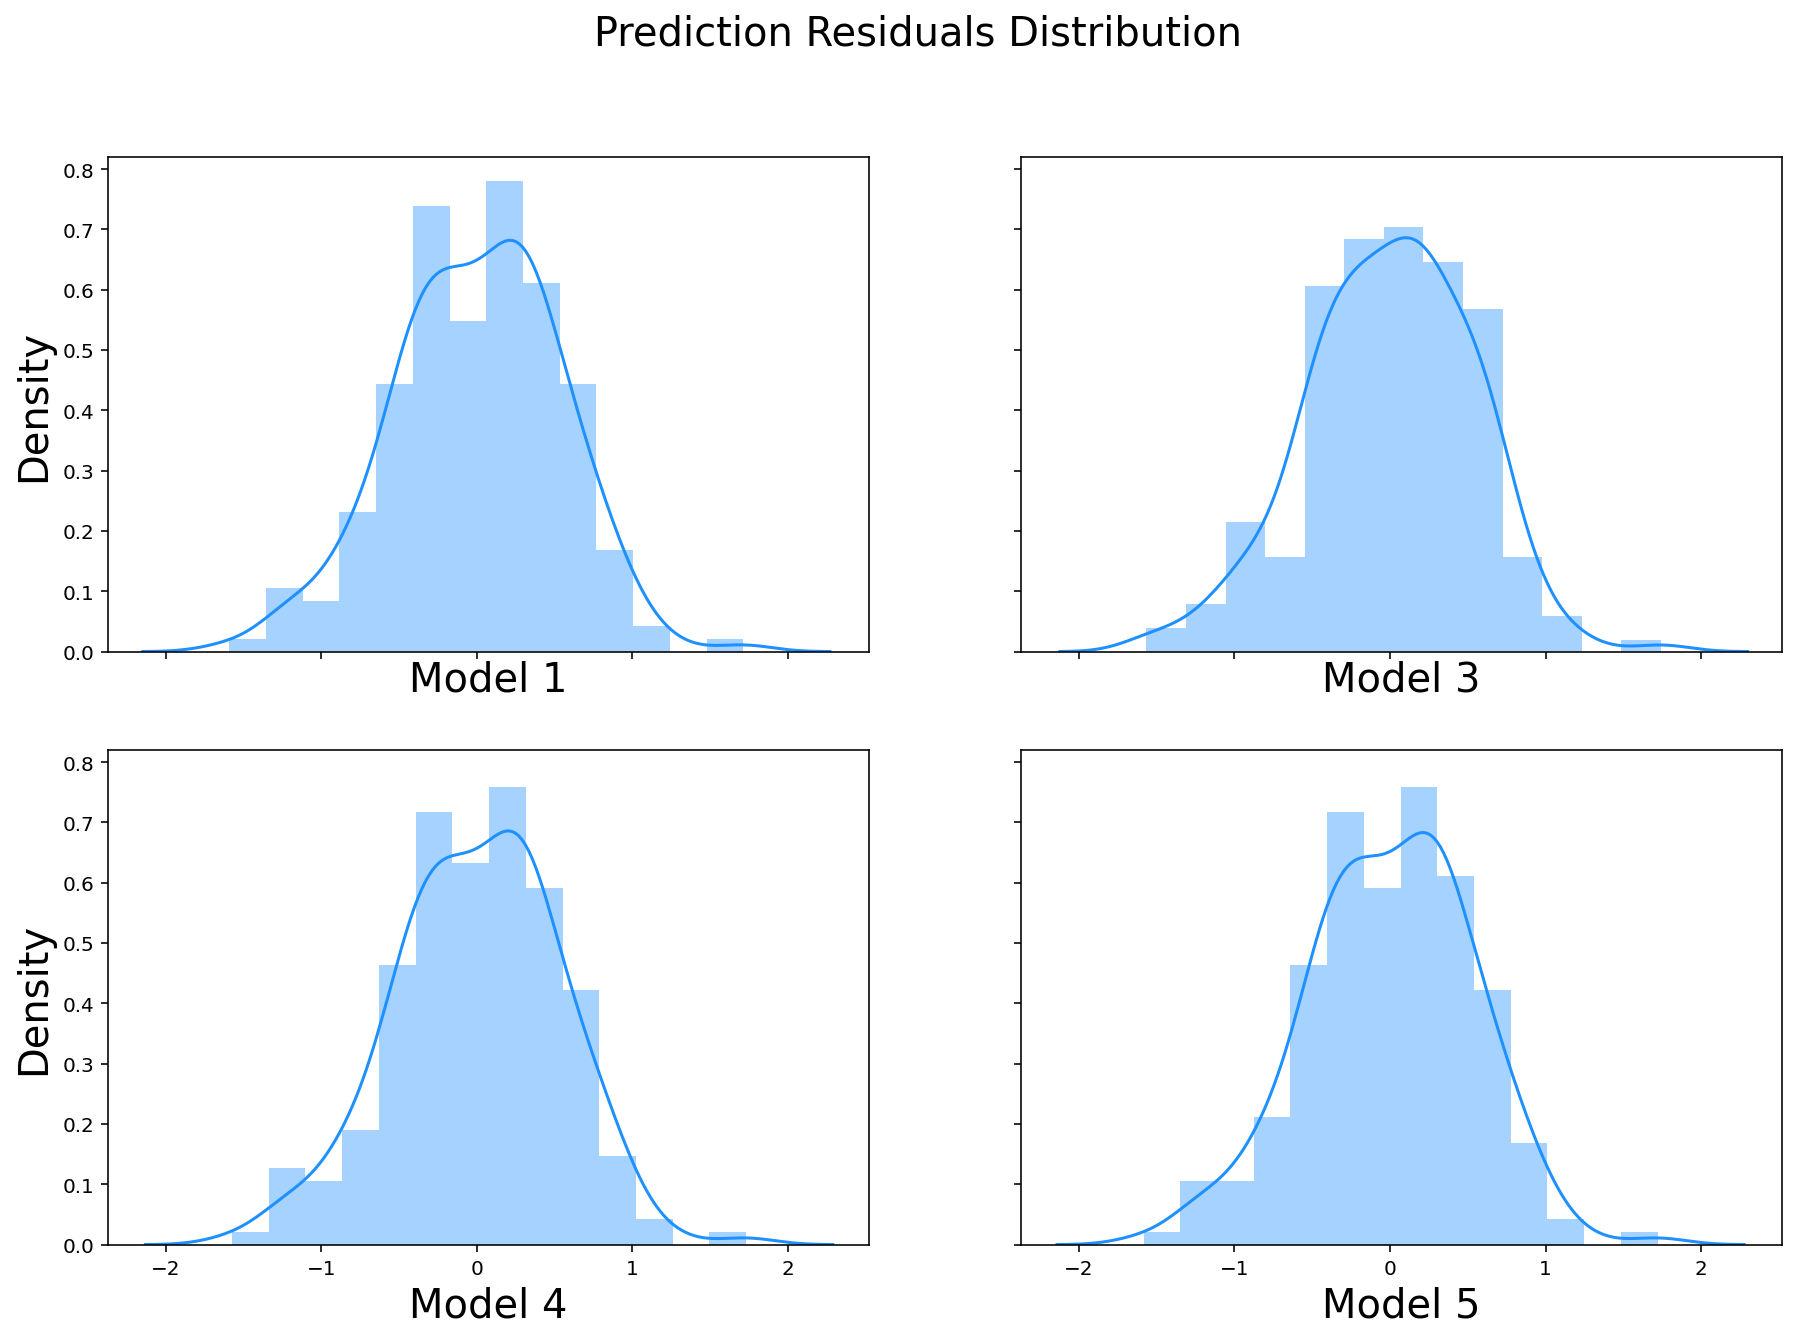

In [22]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(15,10))
fig.suptitle('Prediction Residuals Distribution', size=20)

ax[0,0].set(xlabel='Model 1')
ax[0,1].set(xlabel='Model 3')
ax[1,0].set(xlabel='Model 4')
ax[1,1].set(xlabel='Model 5')

sns.distplot(errors1, color="dodgerblue", ax=ax[0,0], axlabel='Model 1')
#sns.distplot(errors2, color="dodgerblue", ax=ax[0], axlabel='Model 2', bins=201);
sns.distplot(errors3, color="dodgerblue", ax=ax[0,1], axlabel='Model 3')
sns.distplot(errors4, color="dodgerblue", ax=ax[1,0], axlabel='Model 4')
sns.distplot(errors5, color="dodgerblue", ax=ax[1,1], axlabel='Model 5');

for each in ax.flat:
    each.xaxis.get_label().set_fontsize(20)
    each.yaxis.get_label().set_fontsize(20);

### 2.5a: QQ plot

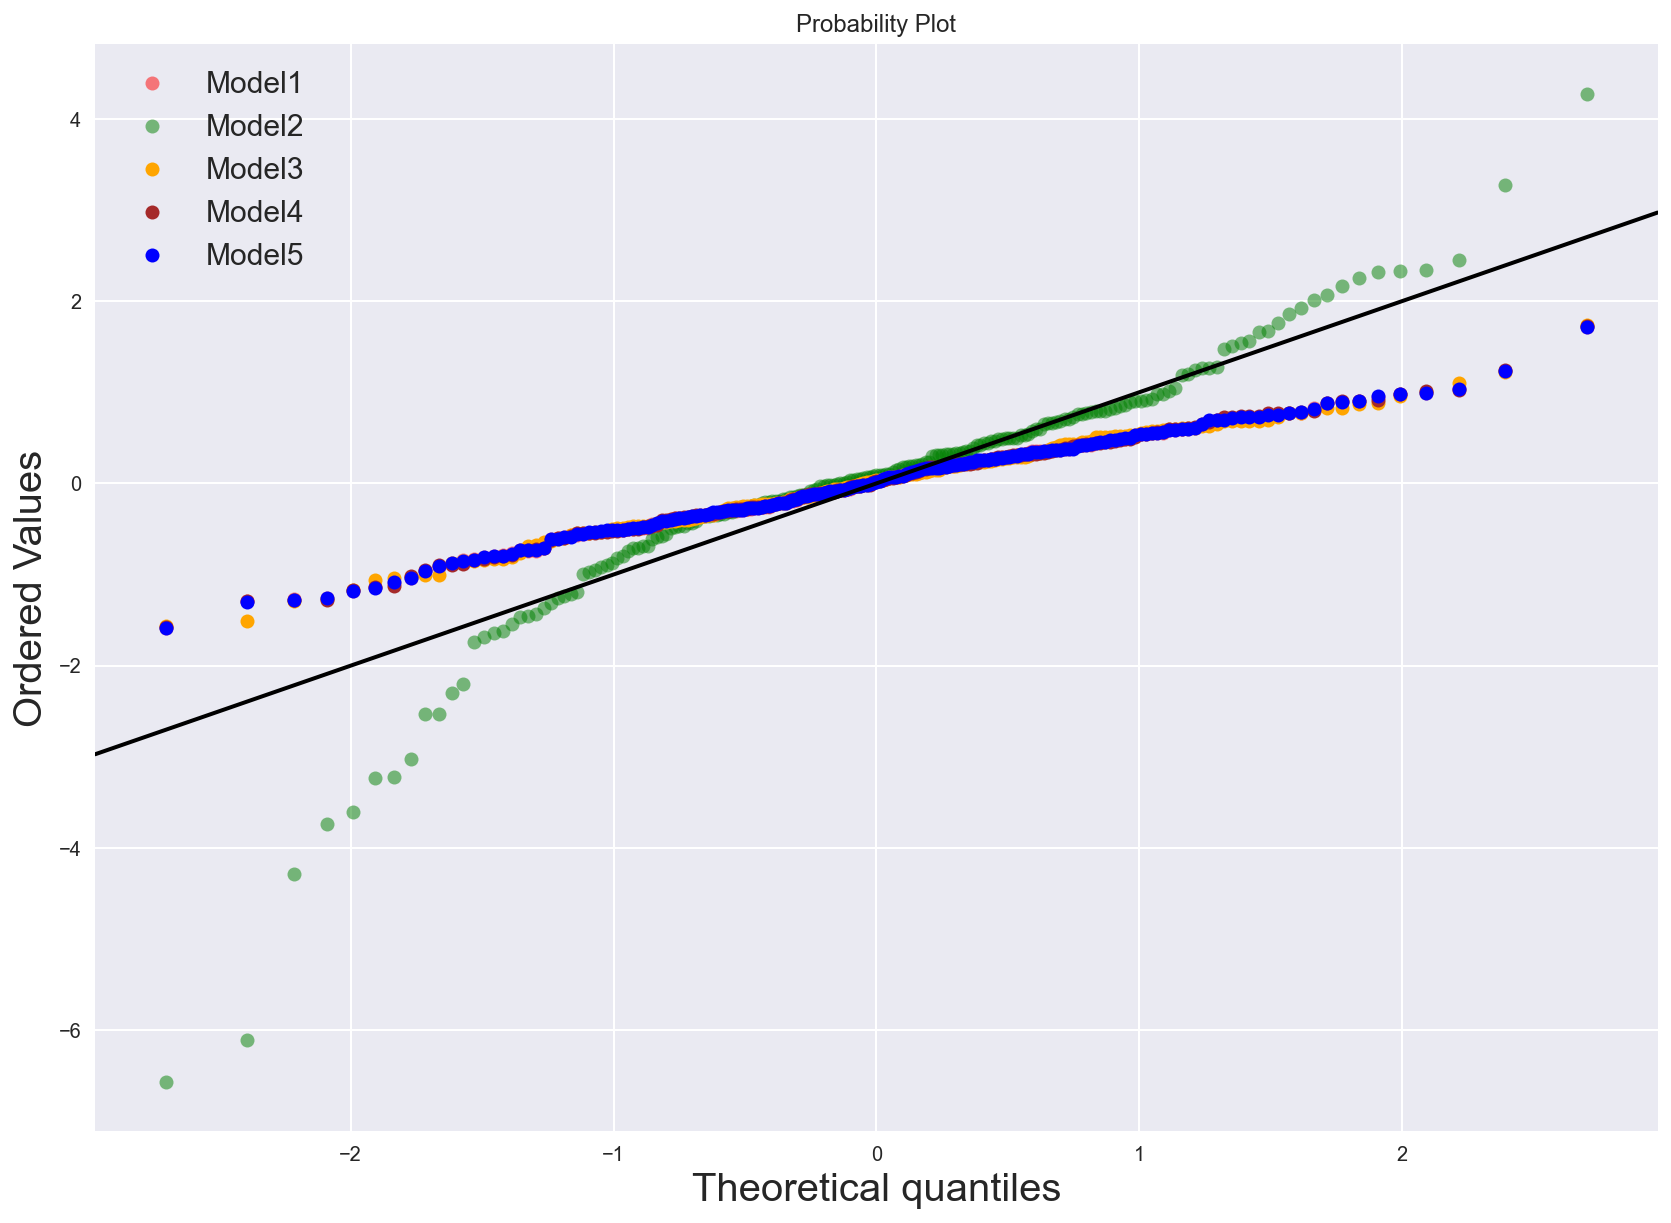

In [23]:
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
stats.probplot(errors1, dist=stats.norm, plot=plt, fit=False)
stats.probplot(errors2, dist=stats.norm, plot=plt, fit=False)
stats.probplot(errors3, dist=stats.norm, plot=plt, fit=False)
stats.probplot(errors4, dist=stats.norm, plot=plt, fit=False)
stats.probplot(errors5, dist=stats.norm, plot=plt, fit=False)

# Remove the regression lines
ax.get_lines()[1].remove()
ax.get_lines()[2].remove()
ax.get_lines()[3].remove()
ax.get_lines()[4].remove()
ax.get_lines()[5].remove()

# Set size of scatter
for each in range(0,2):
    ax.get_lines()[each].set_markersize(7.0)
    ax.get_lines()[each].set_alpha(0.5) 

# Change colour of scatter
ax.get_lines()[0].set_markerfacecolor('red')
ax.get_lines()[1].set_markerfacecolor('green')
ax.get_lines()[2].set_markerfacecolor('orange')
ax.get_lines()[3].set_markerfacecolor('brown')
ax.get_lines()[4].set_markerfacecolor('blue')

# Add on y=x line
ax.axline([0, 0], [1, 1], c='black')
ax.get_lines()[5].set_linewidth(2)
plt.legend((ax.get_lines()[0], 
            ax.get_lines()[1], 
            ax.get_lines()[2],
            ax.get_lines()[3], 
            ax.get_lines()[4]),
            ('Model1','Model2','Model3','Model4','Model5'), fontsize=15);
            


ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20);

### Task 2.6:
Select ‘best’ regression model according to the AIC, BIC and distribution of model residuals from the 5 candidate models, and explain why you would like to choose this specific model.

#### Answer:
The Best regression model is **model 3**. This is because it has the lowest values for AIC and BIC. Additionally, the QQ and error distribution plots show that its error distribution is closest to Normal amongst all 5 models

### Task 2.7:
Split the input and output EEG dataset (𝐗 and 𝐲) into two parts: one part used to train the model, the other used for testing (e.g. 70% for training, 30% for testing). 

For the selected ‘best’ model: 
- 1) estimate model parameters use the training dataset;

- 2) compute the model’s output/prediction on the testing data; and 

- 3) also compute the 95% (model prediction) confidence intervals and plot them (with error bars) together with the model prediction, as well as the testing data samples.


### 2.7.1: Train-test split

In [24]:
# Split dataset
inputsX = combined.drop(['output','time'], axis=1)
outputY = combined['output']

X_train, X_test, y_train, y_test = train_test_split(inputsX, 
                                                    outputY,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=42)

In [25]:
# Train model using least squares
def train_model(training_input, training_output):
    
    x2 = training_input['sig2']
    x1 = training_input['sig1']
    x3 = training_input['sig3']
    ones = np.array(len(training_input)*[1])
    X_matrix = np.transpose([x2, x1**3, x3**4, ones])
    y0 = training_output
    
    theta_hat = np.linalg.inv(np.transpose(X_matrix) @ X_matrix) @ np.transpose(X_matrix) @ y0 
    return theta_hat

# Test Model
def test_model(theta_hat, testing_input):
    
    x2 = testing_input['sig2']
    x1 = testing_input['sig1']
    x3 = testing_input['sig3']
    ones = np.array(len(testing_input)*[1])
    X_matrix = np.transpose([x2, x1**3, x3**4, ones])
    y_hat = X_matrix @ theta_hat 

    return y_hat

# Compute Errors and MSE
def compute_errors(y_hat, testing_output):
    errors = []
    for y,yhat in zip(testing_output, y_hat):
        errors.append(y - yhat)
    
    def square(list):
        return [i ** 2 for i in list]
    
    err_sq = square(errors)
    mse = np.mean(err_sq)
        
    return errors, mse    


### 2.7.2: Train and Test Pipeline

In [26]:
trained_theta_hat = train_model(X_train, y_train)
test_preds = test_model(trained_theta_hat, X_test)
pred_errors,pred_mse = compute_errors(test_preds, y_test)
pred_mse

0.23438101735998348

In [27]:
# Uncomment Below to view trained theta values
trained_theta_hat

array([ 0.04517109,  0.00975114, -0.00201369,  0.41634824])

In [28]:
# Determining Rejection tolerance
pred_mse + 3*np.std(y_test)

5.166030607279559

In [31]:
# Get confidence intervals
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Gets prediction interval.
    
    inputs: 
        - Single prediction, 
        - y_test
        - full test-set preds,
        - Prediction interval threshold (default = .95) 
    outputs: 
        - Prediction interval for single prediction, and prediction itself
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(test_preds)) * sum_errs)
    
    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z = stats.norm.ppf(ppf_lookup)
    interval = z * stdev
    
    #generate prediction interval lower and upper bound
    low, high = prediction - interval, prediction + interval
    
    #return low, prediction, high, interval
    return prediction, interval

# Testing the function outputs for a random value (index 1 in this case)
get_prediction_interval(test_preds[1], y_test.to_list()[1], test_preds)

(-3.876377914710357, 8.265227596653821)

### Plot Confidence Intervals

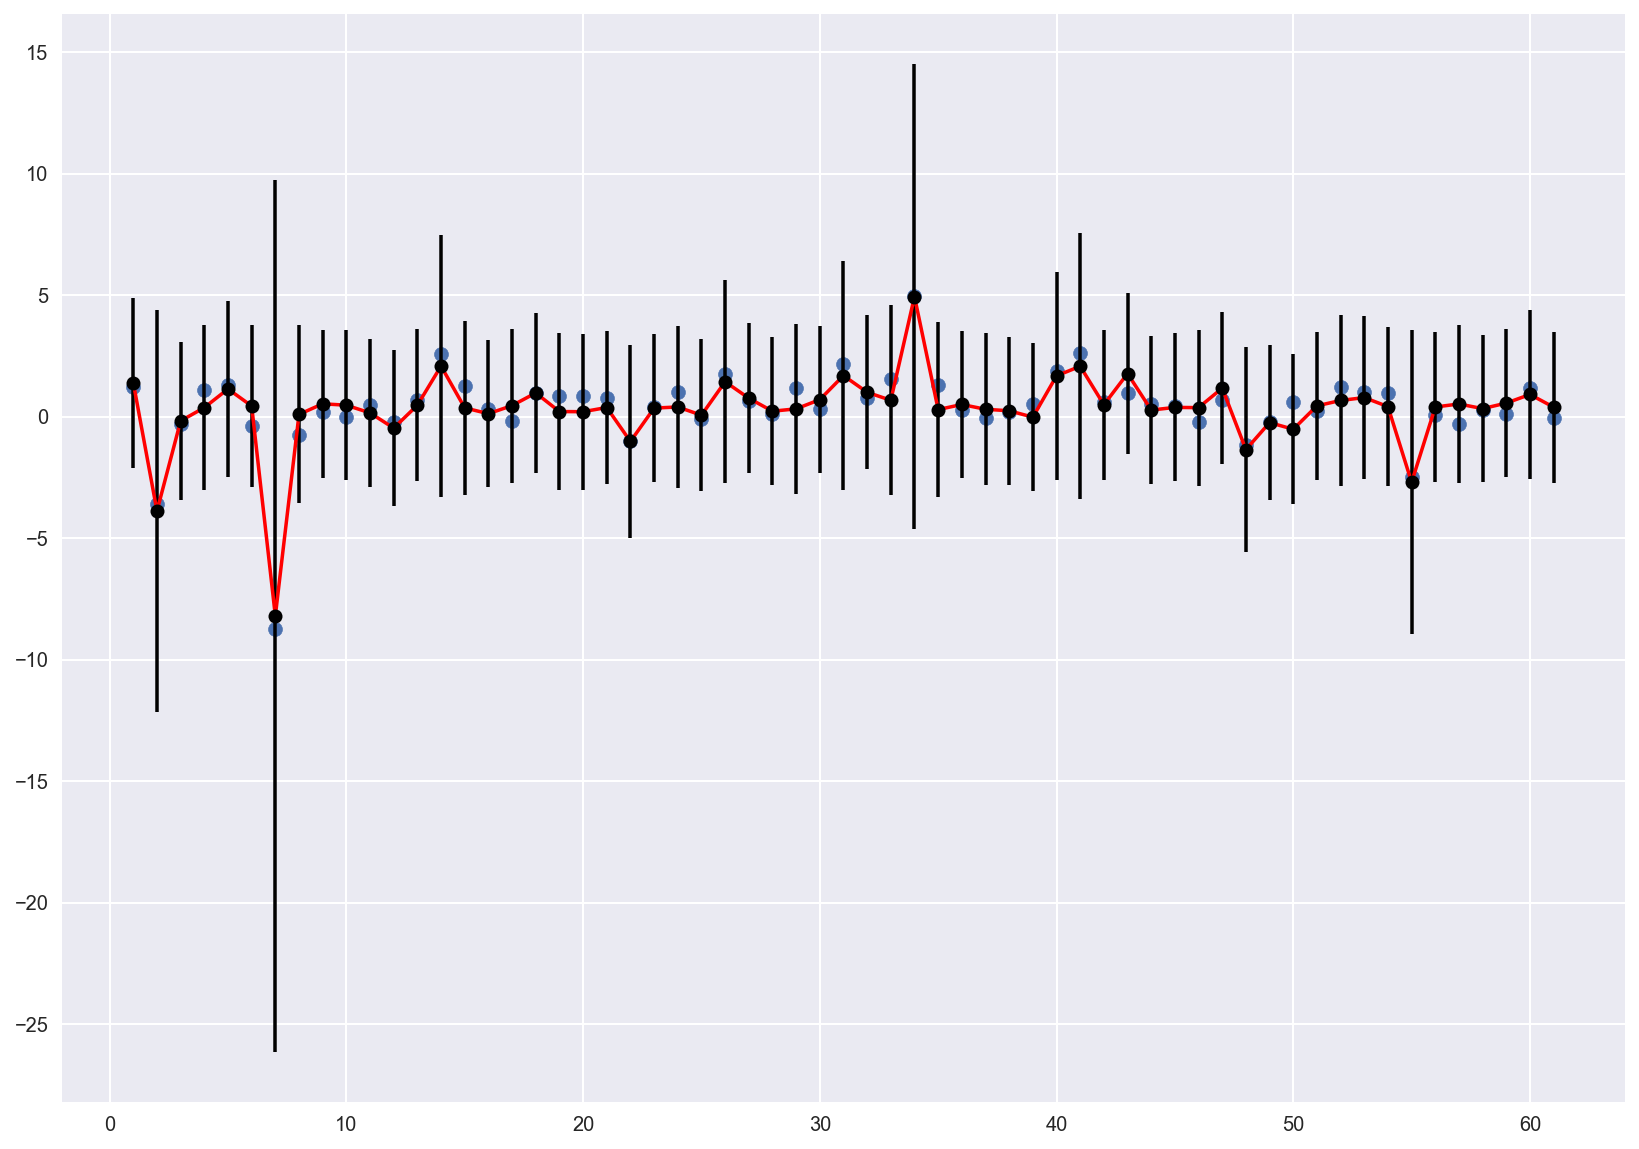

In [32]:
interval_list = []

for a,b in zip(test_preds, y_test.to_list()):
    each = get_prediction_interval(a,b,test_preds)[1]
    interval_list.append(each)

# plot dataset and prediction with interval
x_one = range(1,len(y_test)+1)

fig, ax = plt.subplots(figsize=(14,10))

ax.scatter(x_one, y_test)

plt.plot(x_one, test_preds, color='red')
plt.errorbar(x_one, test_preds, yerr=interval_list, color='black', fmt='o')
plt.show()

## Task 3: Approximate Bayesian Computation (ABC)

Using ‘rejection ABC’ method to compute the posterior distributions of the ‘selected’ regression model parameters in Task 2.

**1)** You only need to compute 2 parameter posterior distributions -- the 2 parameters with largest absolute values in your least squares estimation (Task 2.1) of the selected model. Fix all the other parameters in your model as constant, by using the estimated values from Task 2.1.

**2)** Use a Uniform distribution as prior, around the estimated parameter values for those 2 parameters (from the Task 2.1). You will need to determine the range of the prior distribution.

**3)** Draw samples from the above Uniform prior, and perform rejection ABC for those 2 parameters.

**4)** Plot the joint and marginal posterior distribution for those 2 parameters.

**5)** Explain your results.

### 3.2.  Draw random samples from Prior

In [33]:
# Section 3.2


# Draw random samples
sample_size = 1000000
prior_x2 = np.random.uniform(-2, 2 , size=sample_size)
prior_b  = np.random.uniform(-2, 2, size=sample_size)
param_x1 = np.array(sample_size*[theta_model3[1]])
param_x3 = np.array(sample_size*[theta_model3[2]])

# Merge priors into matrix
priors = np.transpose([prior_x2, param_x1, param_x3, prior_b])

# Create Dataframe
priors_df = pd.DataFrame({'prior_x2': prior_x2, 'param_x1': param_x1, 'param_x3': param_x3, 'prior_b': prior_b})


In [34]:
# Create matrix of x predictors, or simply use the design matrix for selected model, Model 3
X_predictor = X_matrix3

### 3.3.   ABC Rejection

In [35]:
# Determining Rejection tolerance
pred_mse + 3*np.std(y_test)

tolerance = 0.5
posterior = pd.DataFrame(columns=['theta1', 'theta2', 'theta3', 'bias'])

for m in range(0, len(priors_df)):
    candidate = priors[m]
    simulated = X_predictor @ candidate
    
    MSE = np.mean((y0 - simulated)**2)
    
    
    if MSE < tolerance:
        df_length = len(posterior)
        posterior.loc[df_length] = candidate
        
print(f'{len(posterior)} candidates accepted')


18741 candidates accepted


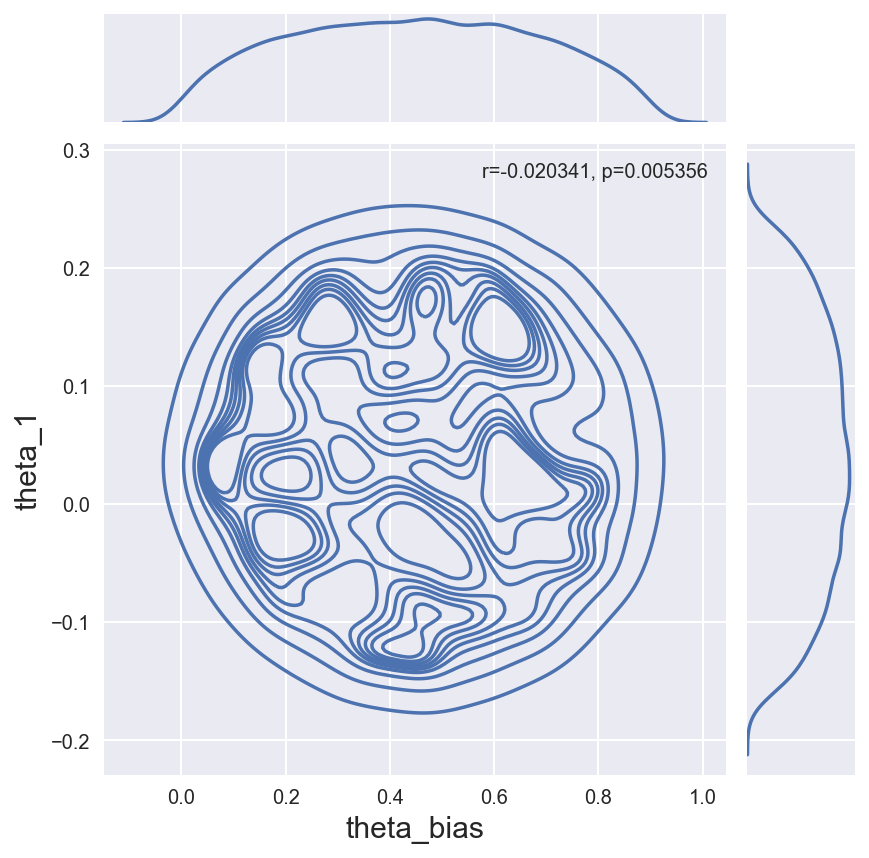

In [36]:
graph = sns.jointplot(data=posterior, x='bias', y='theta1', kind='kde')#, stat_func=stats.pearsonr);
rst, pst = stats.pearsonr(posterior['bias'], posterior['theta1'])
phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(rst,pst)])

graph.set_axis_labels(xlabel='theta_bias', ylabel='theta_1', size=15);

#### 3.4   MAP estimate

[0.02420759]


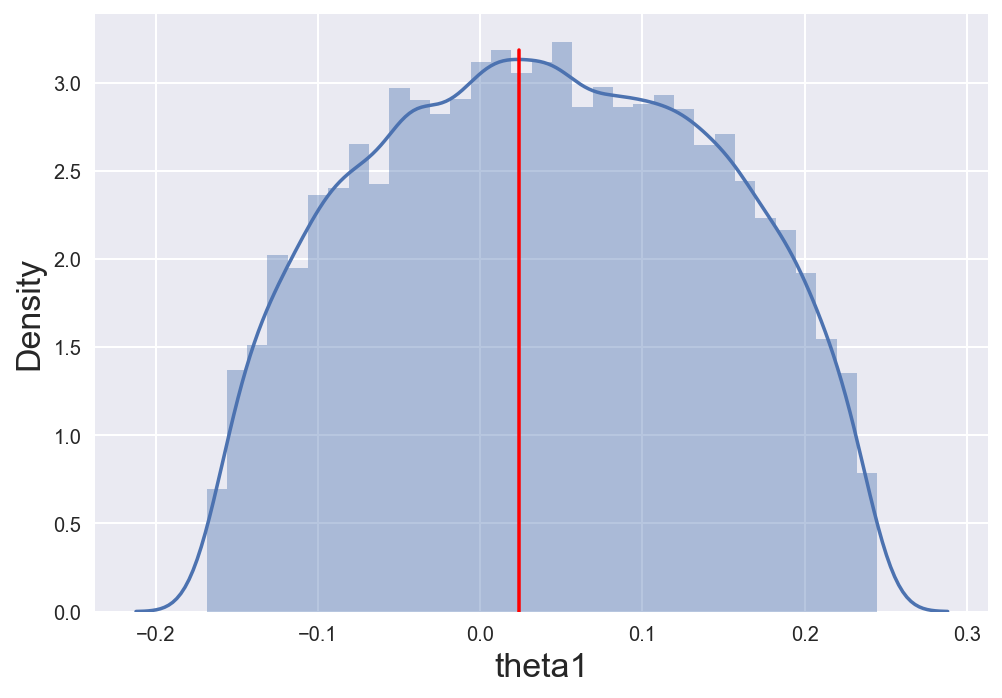

In [37]:
def obtain_MAP(parameter):

    parameter = str(parameter)
    ax = sns.distplot(posterior[parameter])
    ax.xaxis.get_label().set_fontsize(17)
    ax.yaxis.get_label().set_fontsize(17);
    data_x, data_y = ax.lines[0].get_data()
    
    map_x = data_x[np.where(data_y == data_y.max())]
    ax.axvline(map_x, ymax=0.94, color='red')
    print(map_x)

obtain_MAP('theta1')

[0.47323976]


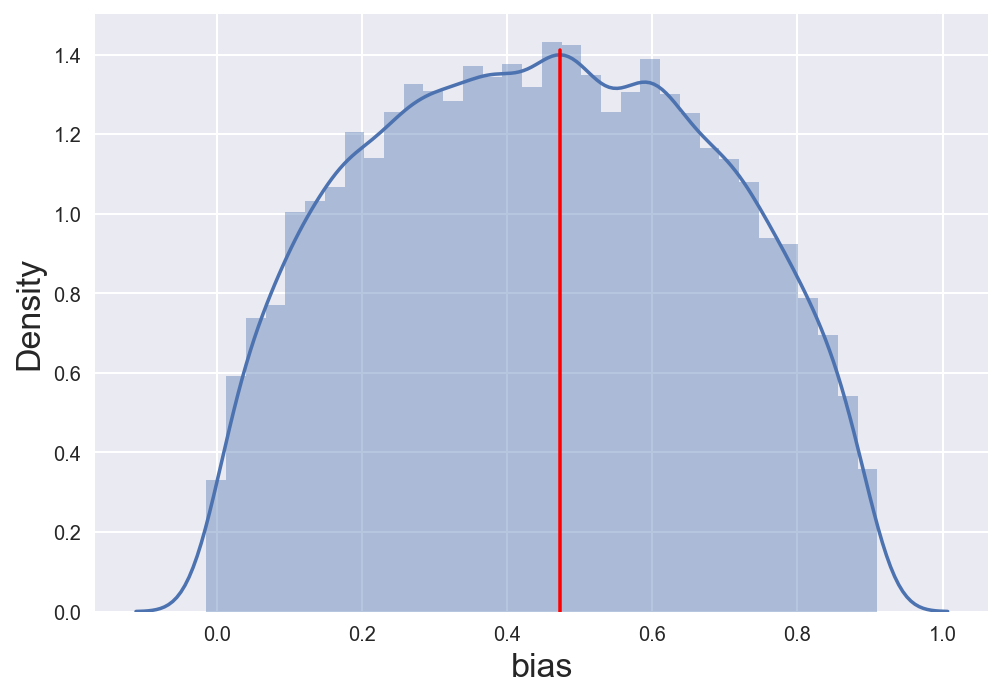

In [38]:
obtain_MAP('bias')